In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2024-11-15 10:36:48.333424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 10:36:48.333461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 10:36:48.334945: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 10:36:48.342838: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '../final_dataset1'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

Found 4834 images belonging to 2 classes.
Found 1035 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


In [4]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

2024-11-15 10:36:53.344855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [5]:
#Final layers set
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [6]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [7]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5


2024-11-15 10:37:47.609677: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2024-11-15 10:37:51.299397: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb3549812e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-15 10:37:51.299427: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2024-11-15 10:37:51.307936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731667071.417382    6052 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 [==============================] - 131s 585ms/step - loss: 0.0266 - accuracy: 0.9899 - val_loss: 2.6147e-04 - val_accuracy: 1.0000
Epoch 2/5
152/152 [==============================] - 74s 484ms/step - loss: 2.0125e-04 - accuracy: 1.0000 - val_loss: 2.2954e-04 - val_accuracy: 1.0000
Epoch 3/5
152/152 [==============================] - 74s 487ms/step - loss: 2.3890e-05 - accuracy: 1.0000 - val_loss: 1.6713e-04 - val_accuracy: 1.0000
Epoch 4/5
152/152 [==============================] - 74s 485ms/step - loss: 1.8071e-05 - accuracy: 1.0000 - val_loss: 1.2952e-04 - val_accuracy: 1.0000
Epoch 5/5
152/152 [==============================] - 75s 490ms/step - loss: 1.4247e-05 - accuracy: 1.0000 - val_loss: 1.0788e-04 - val_accuracy: 1.0000


In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

33/33 [==============================] - 16s 480ms/step - loss: 2.2146e-04 - accuracy: 1.0000
Test accuracy: 1.0


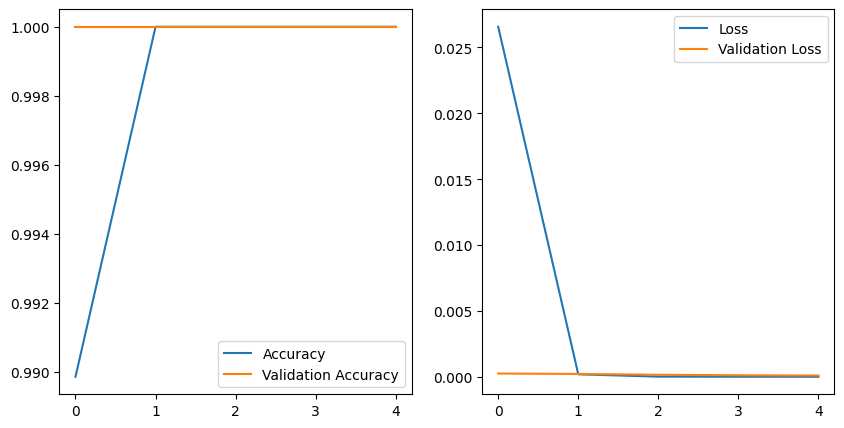

In [10]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [11]:
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

33/33 [==============================] - 24s 432ms/step


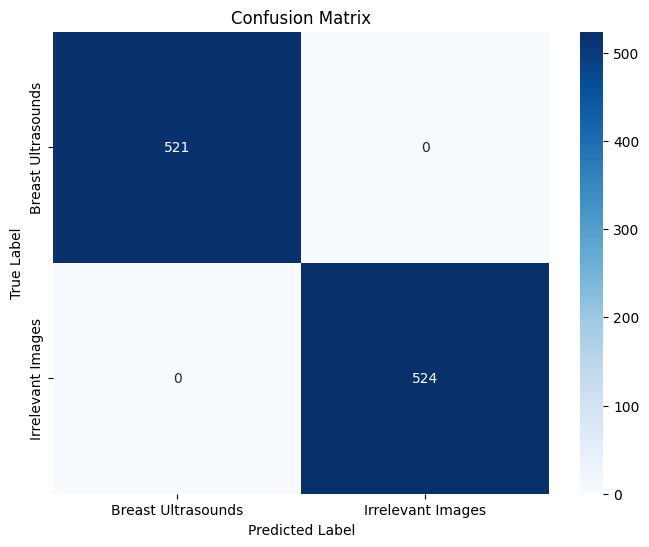

In [12]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)

#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Breast Ultrasounds', 'Irrelevant Images'], yticklabels=['Breast Ultrasounds', 'Irrelevant Images'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
model.save('NASNet_2class_high')

INFO:tensorflow:Assets written to: NASNet_2class_high/assets


INFO:tensorflow:Assets written to: NASNet_2class_high/assets
